# Выбор наиболее прибыльной локации для добычи нефти

## Введение

**Вводные данные проекта:**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Целью проекта является** выбор 200 лучших локации для бурения скважин с возможной максимальной суммарной прибылью при ограниченном бюджете на разработку скважин в регионе 10 млрд руб. и с вероятностью убытков меньше 2.5%.

**Этапы проекта:**
1. Загрузить и подготовить данные
2. Обучить и проверить модель линейной регрессии для каждого региона 
3. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины
4. Рассчитать прибыль для полученного объёма сырья
5. Оценить риски и прибыль для каждого региона с применением техники Bootstrap
6. Предложить регион для разработки скважин и обосновать выбор

**Описание данных**

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

### Изучение общей информации о данных

In [122]:
# импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import markdown

In [123]:
# КОНСТАНТЫ
# общее количество исследуемых скважин
TOTAL_NUMBER_OF_WELLS = 500

# лучшие скважины, выбранные для разработки
BEST_NUMBER_OF_WELLS = 200

# доход с единицы продукта (одной тысячи баррелей)
INCOME_ONE_PRODUCT = 450e3

# запланированные затраты на разработку скважин в регионе
PLAN_COSTS = 10e9

# верхняя граница риска убытка
UPPER_LIMIT_OF_RISK = 0.025

In [46]:
def info_all(data):
    '''функция оценивает общую информацию о данных'''
    print('-'*50)
    print('Общая информация о данных')
    temp = data.copy() 
    list_c = data.columns
    print(temp.info())
    for col_l in list_c:
        print('-'* 25)
        print(col_l, temp[col_l].sort_values().unique())
        print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')
    print('-'*50)    
    display(data.describe()) 
    print('-'*50) 
    print('Поиск дубликатов')
    if data.duplicated().sum() == 0:
        print('Дубликаты по строкам отсутствуют')
    else:
        print('Количество дублирующихся строк:', data.duplicated().sum())
    if data['id'].duplicated().sum() == 0:
        print('Дубликаты в столбце id отсутствуют')
    else:
        print('Количество дубликатов в id:', data['id'].duplicated().sum())
        duplic_list = data.loc[data['id'].duplicated() == True]['id']
        print('Дубликаты по  id')
        display(data.query('id in @duplic_list').sort_values('id'))

In [47]:
# откроем файл с данными по 1-му региону
data_1 = pd.read_csv('/datasets/geo_data_0.csv')

# посмотрим общую информацию о данных
print('Регион 1')
info_all(data_1)

Регион 1
--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-------------------------
id ['006OJ' '009eY' '00AfQ' ... 'zztWK' 'zzyhQ' 'zzzLH']
id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f0 [-1.40860531 -1.35177299 -1.30222711 ...  2.33375269  2.33707957
  2.36233081]
f0 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f1 [-0.8482185  -0.84490792 -0.8205609  ...  1.33334561  1.33482762
  1.34376933]
f1 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f2 [-12.08832812 -10.13834135 -10.13

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют
Количество дубликатов в id: 10
Дубликаты по  id


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


В данных по региону 1 найдены дубликаты по id. В связи с тем, что признаки обезличены, нет возможности разобраться в причине возникновения этих дубликатов. Их объединение будет не корректным. Так же нет возможности проверить какая из строк является корректной. Количество дубликатов небольшое (10), поэтому удалим их (20 строк).

In [48]:
data_1 = data_1.drop_duplicates(subset='id', keep=False)
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99980 non-null  object 
 1   f0       99980 non-null  float64
 2   f1       99980 non-null  float64
 3   f2       99980 non-null  float64
 4   product  99980 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


Так как id не будут участвовать как признак в обучении модели установим его в качестве индекса.

In [49]:
# установим столбец id в качестве индекса
data_1 = data_1.set_index('id')
display(data_1.head())

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


In [50]:
# откроем файл с данными по 2-му региону
data_2 = pd.read_csv('/datasets/geo_data_1.csv')

# посмотрим общую информацию о данных
print('Регион 2')
info_all(data_2)

Регион 2
--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-------------------------
id ['0022J' '003Gl' '003Vx' ... 'zzv4E' 'zzy2c' 'zzzvI']
id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f0 [-31.60957602 -27.82961614 -26.64625507 ...  28.93082879  29.25906208
  29.42175461]
f0 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f1 [-26.35859801 -25.38962242 -25.2915177  ...  16.0268693   16.7371962
  18.73406263]
f1 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f2 [-0.01814409 -0.017886

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют
Количество дубликатов в id: 4
Дубликаты по  id


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


С дубликатами по id поступим также как в регионе 1 - удалим их.

In [51]:
data_2 = data_2.drop_duplicates(subset='id', keep=False)
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [52]:
# установим столбец id в качестве индекса
data_2 = data_2.set_index('id')
display(data_2.head())

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


In [53]:
# откроем файл с данными по 3-му региону
data_3 = pd.read_csv('/datasets/geo_data_2.csv')

# посмотрим общую информацию о данных
print('Регион 3')
info_all(data_3)

Регион 3
--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-------------------------
id ['009Gl' '00AuD' '00CaL' ... 'zzqqy' 'zzsKd' 'zzz9h']
id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f0 [-8.76000362 -7.45058711 -7.18949804 ...  7.19461485  7.21552717
  7.23826248]
f0 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f1 [-7.08401976 -6.74835677 -6.73299712 ...  7.10161842  7.76185714
  7.84480127]
f1 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f2 [-11.97033454 -11.61169048 -11.40

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют
Количество дубликатов в id: 4
Дубликаты по  id


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


В третьем регионе также есть дубликаты по id. Удалим эти строки.

In [54]:
data_3 = data_3.drop_duplicates(subset='id', keep=False)
data_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [55]:
# установим столбец id в качестве индекса
data_3 = data_3.set_index('id')
display(data_3.head())

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


### Вывод по анализу общей информации о данных


- в данных отсутствуют пропуски
- тип данных определен верно
- дубликаты по строкам отсутствуют
- удалены дубликаты по id (все строки у которых обнаружены дубли), так как количество не велико, а разобраться в достоверности той или иной информации по id не представляется возможным
- столбец id установлен в качестве индекса
- некоторые признаки могут иметь выбросы, необходимо посмотреть боксплоты

## Предобработка данных

### Оценка корреляции признаков

In [56]:
def corr(data, region):
    '''оцениваем корреляцию с помощью графика'''
    sns.pairplot(data)
    plt.suptitle(f'Оценка влияния параметров на целевой признак регион {region}', y=1.05)
    plt.gcf().set_size_inches(13,13)
    plt.show()

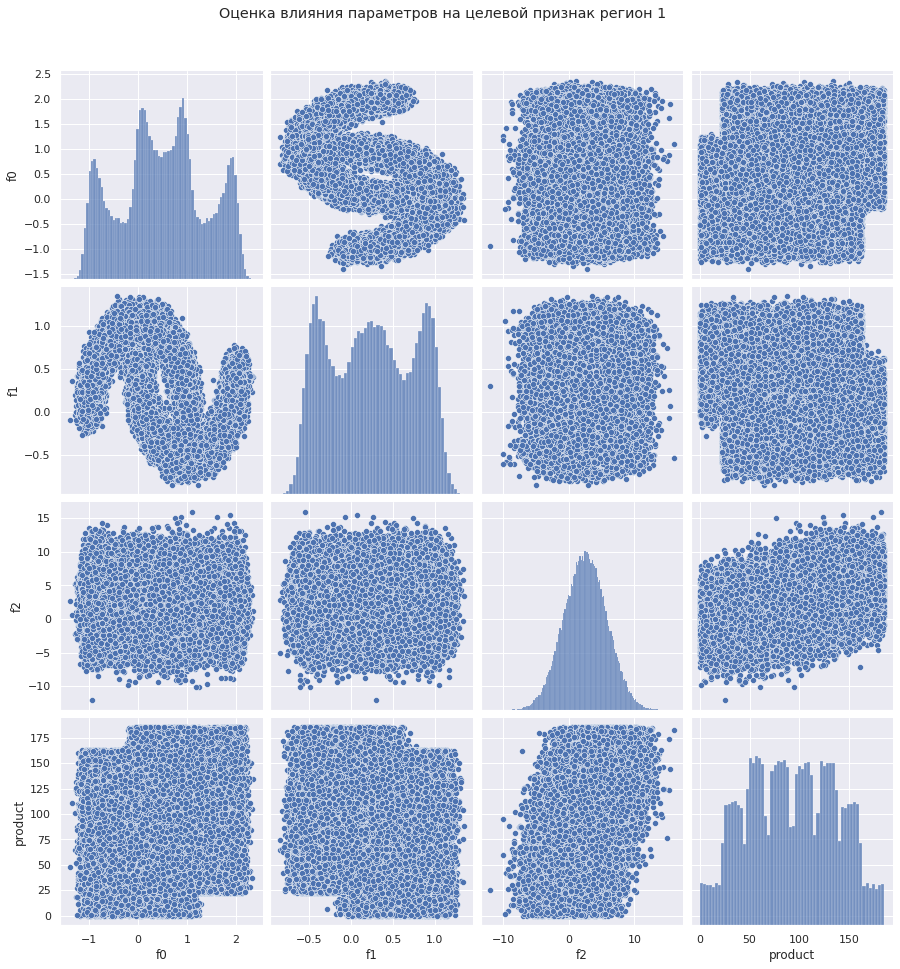

In [57]:
# регион 1
corr(data_1, 1)

Между целевым признаком (product) и f2 наблюдается слабая положительная корреляция.

Между признаками f0 и f1 наблюдается сложная нелинейная зависимость, по остальным признакам корреляция не выявлена. 

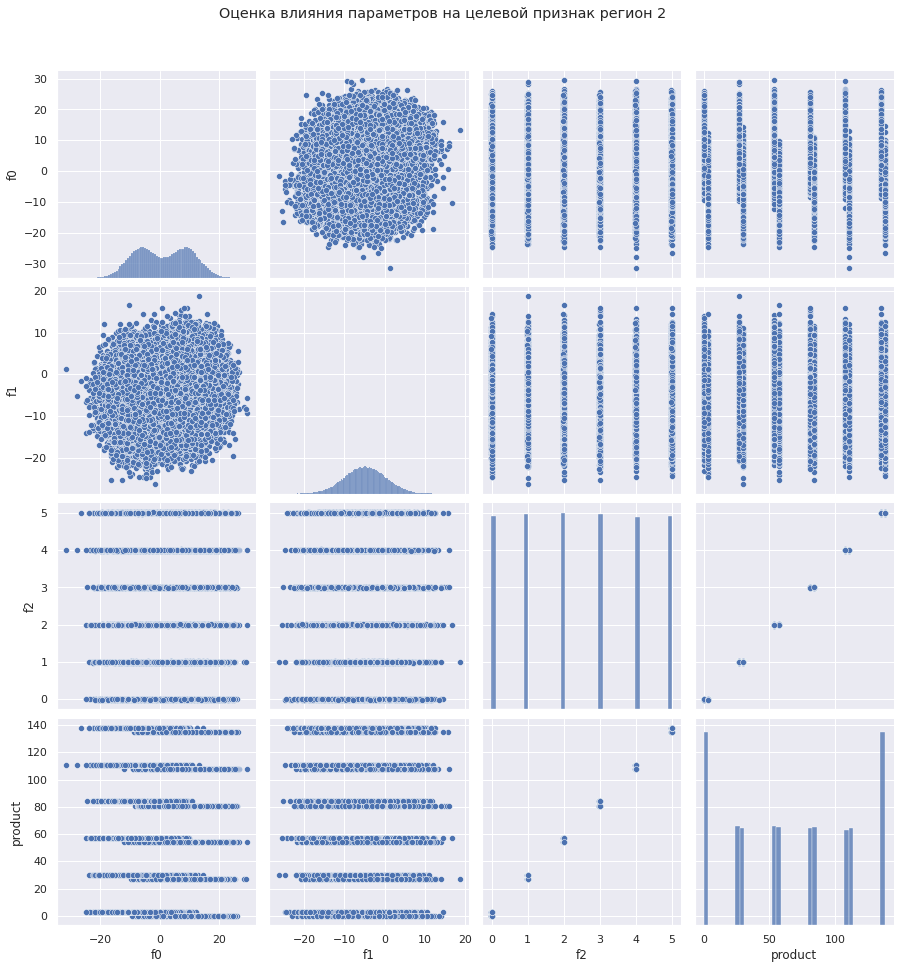

In [58]:
# регион 2
corr(data_2, 2)

Между целевым признаком и f2 наблюдается выраженная положительная корреляция - в этом регионе взаимосвязь сильнее, чем в регионе 1. 

В целом диаграмма рассеивания по 2-му региону значительно отличается от 1-го региона - каждый регион имеет свою специфику.

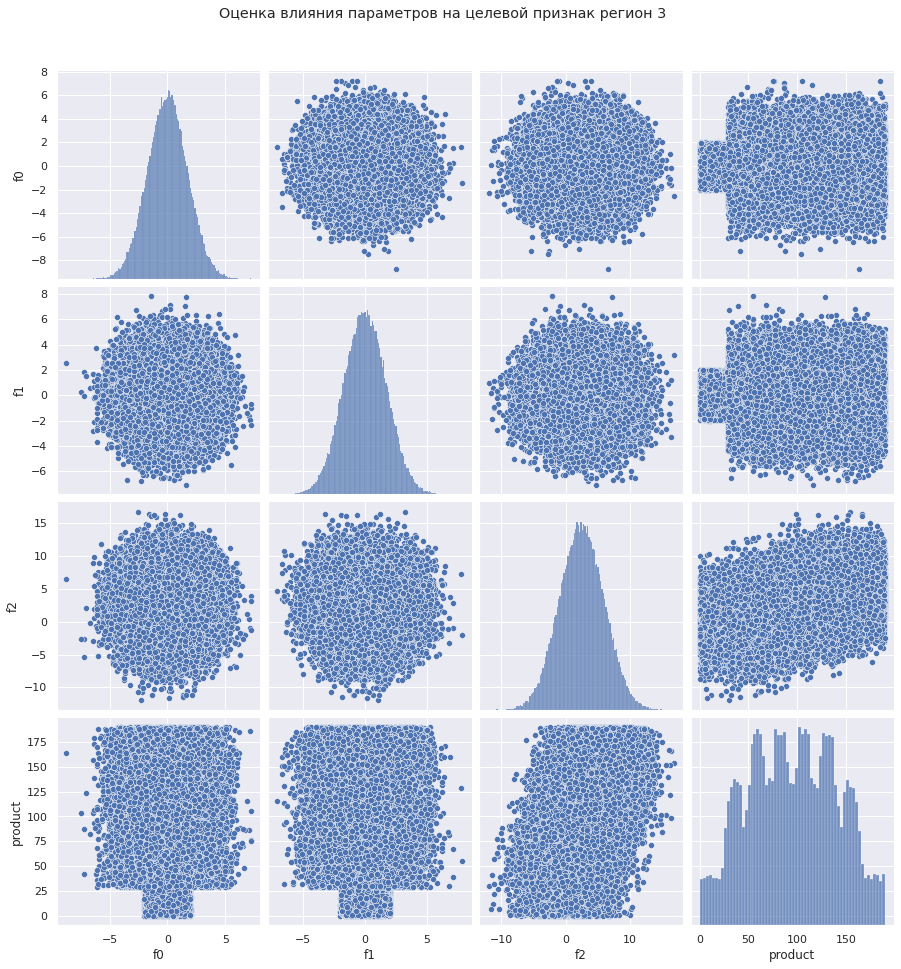

In [59]:
# регион 3
corr(data_3, 3)

Регион 3 отличается нормальным распределением всех нецелевых признаков f0, f1, f2 - что не наблюдалось в регионах 1 и 2.

Корреляция между целевым признаком и f2 слабая положительная, схожа с регионом 1.

### Оценка распределения количественных признаков

In [60]:
columns_name = ['f0','f1','f2','product']
def graph(data, data_box, data_label, num_bins, log_scale=False):
    '''строит гистограммы histplot и boxplot'''
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.histplot(data, bins=num_bins,  ax=axes[0], color='c', kde=True)
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=data_box, x=data_label, ax=axes[1], color='mediumturquoise')
    plt.show()

#### Регион 1

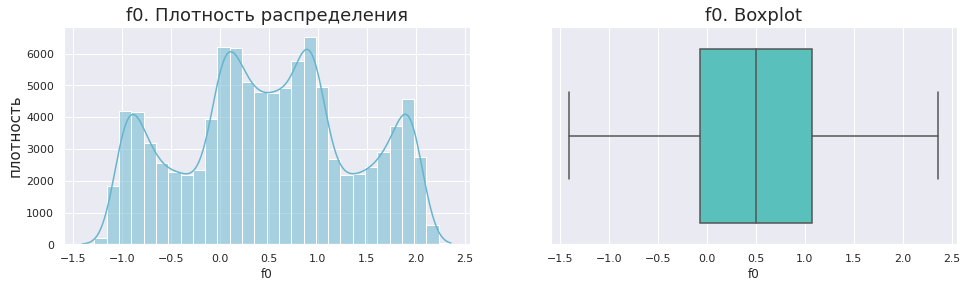

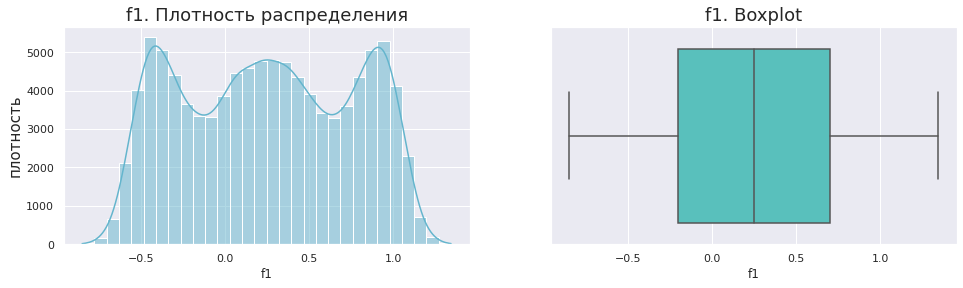

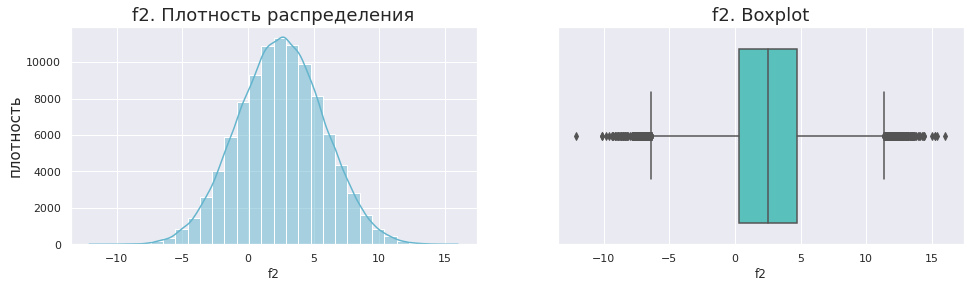

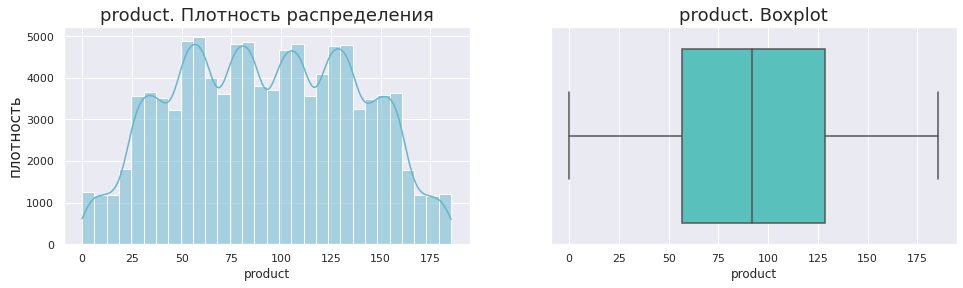

In [61]:
# построим графики по региону 1
for name in columns_name:
    graph(data_1[name], data_1, name, num_bins=30)

In [62]:
# посмотрим распределение целевого признака
data_1['product'].describe()

count    99980.000000
mean        92.499166
std         44.289044
min          0.000000
25%         56.496513
50%         91.847928
75%        128.564089
max        185.364347
Name: product, dtype: float64

Межквартильный размах целевого признака варьируется от 57 до 129 тыс. баррелей, при этом медианное значение на уровне 92 тыс. баррелей. Далее сравним эти показатели с другими регионами.

В признаке f2 имеются выбросы. Посмотрим какую долю в данных они занимают.

In [63]:
max_f2 = (data_1['f2'].quantile(0.75) - data_1['f2'].quantile(0.25))*1.5 + data_1['f2'].quantile(0.75)
min_f2 = (data_1['f2'].quantile(0.25)-(data_1['f2'].quantile(0.75)-data_1['f2'].quantile(0.25))*1.5)

print('Доля выбросов в признаке f2 региона 1:', round((data_1.query('f2 < @min_f2 | f2 > @max_f2')['f2']
                                                      .count()/data_1.shape[0]*100), 2), '%')

Доля выбросов в признаке f2 региона 1: 0.51 %


Доля выбросов не велика, поэтому лучше очистить данные от них.

In [64]:
data_1 = data_1.loc[(data_1['f2'] <= max_f2) & (data_1['f2'] >= min_f2)]
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99473 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99473 non-null  float64
 1   f1       99473 non-null  float64
 2   f2       99473 non-null  float64
 3   product  99473 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


#### Регион 2

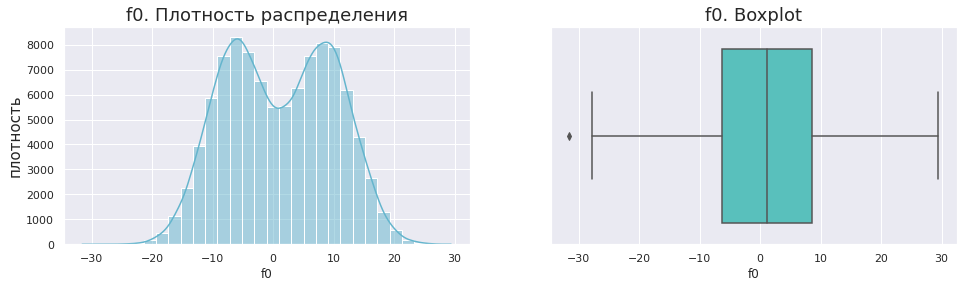

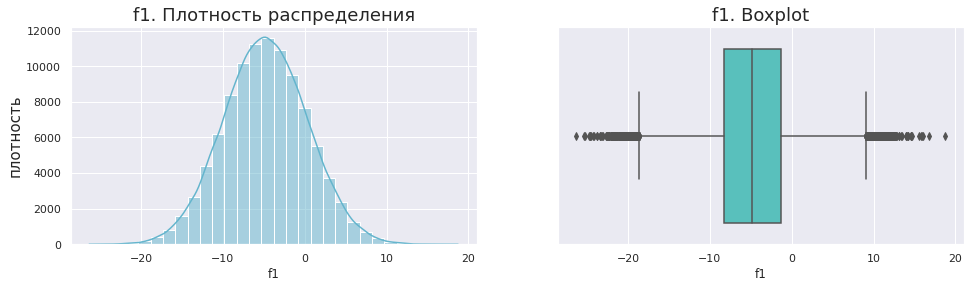

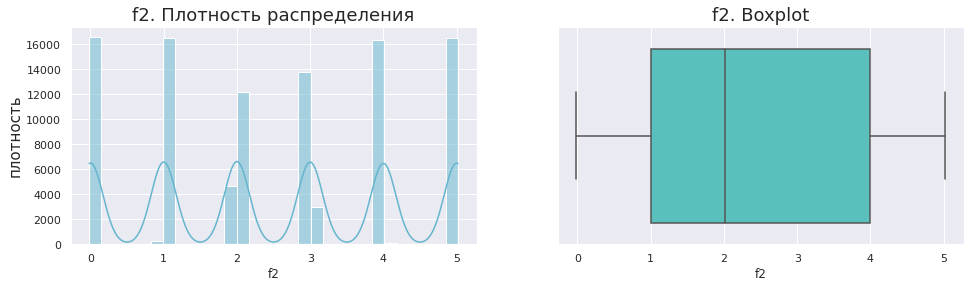

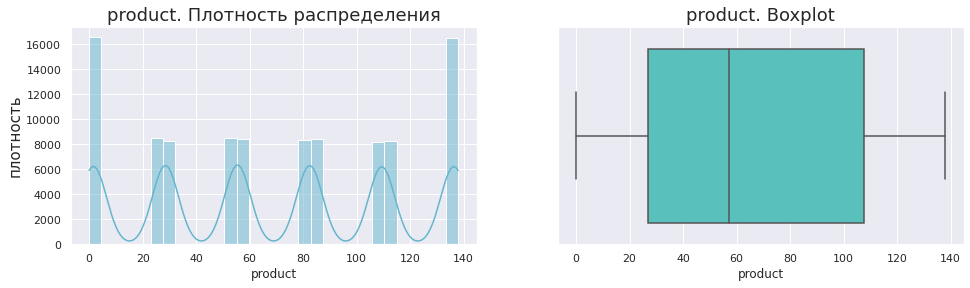

In [65]:
# построим графики по региону 2
for name in columns_name:
    graph(data_2[name], data_2, name, num_bins=30)

In [66]:
# посмотрим распределение целевого признака
data_2['product'].describe()

count    99992.000000
mean        68.824148
std         45.944889
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64

Если оценить распределение целевого признака (product), то можно отметить большое количество скважин с 0 запасом и такое же количество с достаточно большим запасом (около 140 тыс. баррелей). При этом межквартильный размах достаточно большой - от 27 до 108 тыс. баррелей, медиана находится в районе 57 тыс. баррелей. Данные показатели хуже, чем в регионе 1.

В регионе наблюдаются выбросы в признаках f0 и f1. Посмотрим их долю.

In [67]:
max_f1 = (data_2['f1'].quantile(0.75) - data_2['f1'].quantile(0.25))*1.5 + data_2['f1'].quantile(0.75)
min_f1 = (data_2['f1'].quantile(0.25)-(data_2['f1'].quantile(0.75)-data_2['f1'].quantile(0.25))*1.5)
min_f0 = (data_2['f0'].quantile(0.25)-(data_2['f0'].quantile(0.75)-data_2['f0'].quantile(0.25))*1.5)

print('Доля выбросов в признаке f1 региона 2:', round((data_2.query('f1 < @min_f1 | f1 > @max_f1')['f1']
                                                      .count()/data_2.shape[0]*100), 2), '%')
print('Доля выбросов в признаке f0 региона 2:', round((data_2.query('f0 < @min_f0')['f0']
                                                      .count()/data_2.shape[0]*100), 3), '%')

Доля выбросов в признаке f1 региона 2: 0.64 %
Доля выбросов в признаке f0 региона 2: 0.001 %


Доля выбросов не велика, исключим их.

In [68]:
data_2 = data_2.loc[(data_2['f1'] <= max_f1) & (data_2['f1'] >= min_f1)]
data_2 = data_2.loc[data_2['f0'] >= min_f0]
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99355 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99355 non-null  float64
 1   f1       99355 non-null  float64
 2   f2       99355 non-null  float64
 3   product  99355 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


#### Регион 3

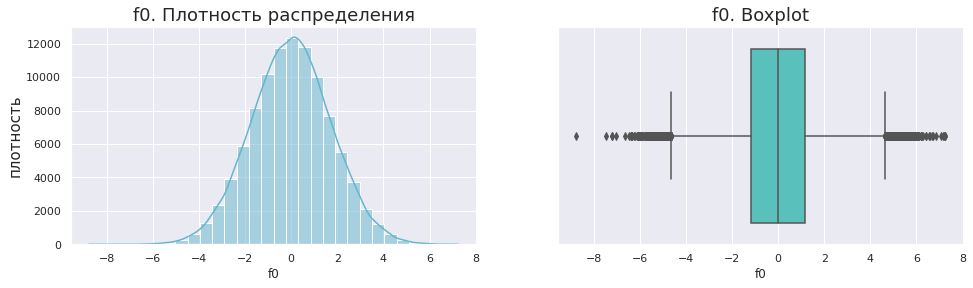

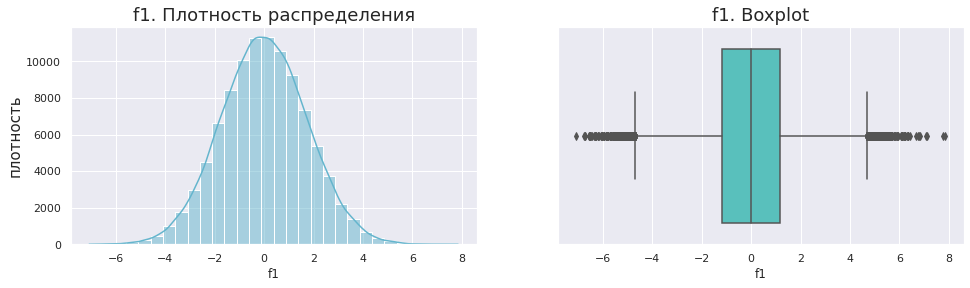

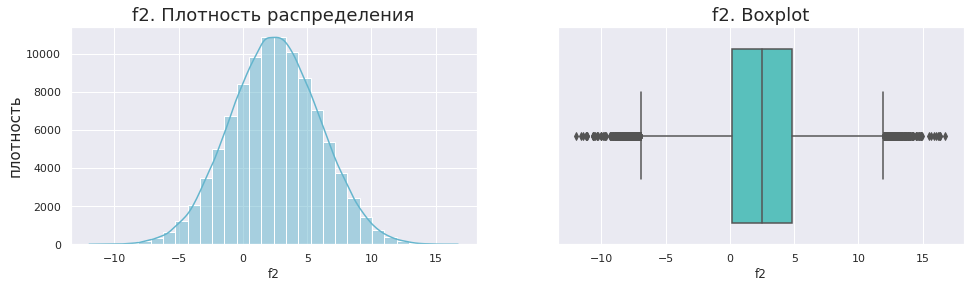

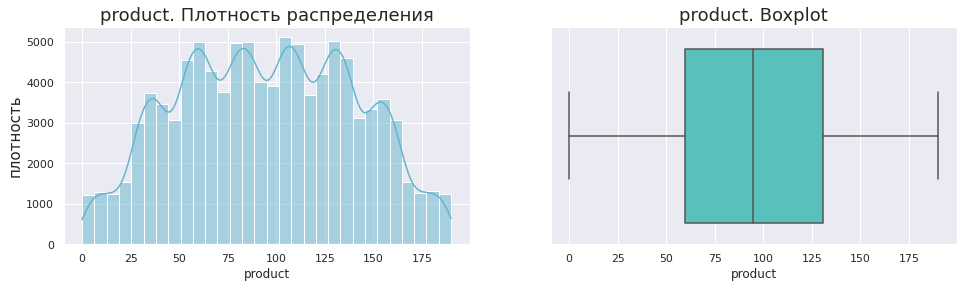

In [69]:
# построим графики по региону 3
for name in columns_name:
    graph(data_3[name], data_3, name, num_bins=30)

In [70]:
# посмотрим распределение целевого признака
data_3['product'].describe()

count    99992.000000
mean        94.998767
std         44.747763
min          0.000000
25%         59.450441
50%         94.925026
75%        130.585544
max        190.029838
Name: product, dtype: float64

Межквартильный размах целевого признака варьируется от 59 до 130 тыс. баррелей, при этом медианное значение на уровне 95 тыс. баррелей. Распределение целевого признака практически идентично региону 1, тем не менее, по региону 3 наблюдаются самые высокие значения объемов запасов по распределению.

По региону 3 имеются выбросы по всем признакам - f0, f1, f2. Посмотрим их долю в данных.

In [71]:
min_f0 = (data_3['f0'].quantile(0.25)-(data_3['f0'].quantile(0.75)-data_3['f0'].quantile(0.25))*1.5)
max_f0 = (data_3['f0'].quantile(0.75) - data_3['f0'].quantile(0.25))*1.5 + data_3['f0'].quantile(0.75)

min_f1 = (data_3['f1'].quantile(0.25)-(data_3['f1'].quantile(0.75)-data_3['f1'].quantile(0.25))*1.5)
max_f1 = (data_3['f1'].quantile(0.75) - data_3['f1'].quantile(0.25))*1.5 + data_3['f1'].quantile(0.75)

min_f2 = (data_3['f2'].quantile(0.25)-(data_3['f2'].quantile(0.75)-data_3['f2'].quantile(0.25))*1.5)
max_f2 = (data_3['f2'].quantile(0.75) - data_3['f2'].quantile(0.25))*1.5 + data_3['f2'].quantile(0.75)

print('Доля выбросов в признаке f0 региона 3:', round((data_3.query('f0 < @min_f0 | f0 > @max_f0')['f0']
                                                      .count()/data_3.shape[0]*100), 2), '%')
print('Доля выбросов в признаке f1 региона 3:', round((data_3.query('f1 < @min_f1 | f1 > @max_f1')['f1']
                                                      .count()/data_3.shape[0]*100), 2), '%')
print('Доля выбросов в признаке f2 региона 3:', round((data_3.query('f2 < @min_f2 | f2 > @max_f2')['f2']
                                                      .count()/data_3.shape[0]*100), 2), '%')

Доля выбросов в признаке f0 региона 3: 0.73 %
Доля выбросов в признаке f1 региона 3: 0.68 %
Доля выбросов в признаке f2 региона 3: 0.58 %


Доля выбросов также не велика, как и в прочих регионах. Удалим выбросы из датафрейма.

In [72]:
data_3 = data_3.loc[(data_3['f0'] >= min_f0) & (data_3['f0'] <= max_f0)]
data_3 = data_3.loc[(data_3['f1'] <= max_f1) & (data_3['f1'] >= min_f1)]
data_3 = data_3.loc[(data_3['f2'] <= max_f2) & (data_3['f2'] >= min_f2)]
data_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97996 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       97996 non-null  float64
 1   f1       97996 non-null  float64
 2   f2       97996 non-null  float64
 3   product  97996 non-null  float64
dtypes: float64(4)
memory usage: 3.7+ MB


### Вывод по итогам предобработки данных

В ходе предобработки данных был проведен корреляционный анализ и оценка распределения признаков с помощью histplot и boxplot.
Были выявлены выбросы в данных по нецелевым признакам в каждом регионе, их процент был незначительным, поэтому принято решение убрать их из данных.

Выводы по итогам предобработки данных по регионам:

1. По анализу диаграммы рассеивания можно сказать, что каждый регион имеет свою специфику - разную силу корреляции между целевым и прочими признаками, распределением признаков и т.д. 

2. Во всех регионах имеется корреляция целевого признака (product) с признаком f2. При этом регионы 1 и 3 схожи по наличию слабой корреляции этих признаков. Регион 2, напротив, отличается их сильной корреляцией.

3. В регионе 3 наблюдается самое удачное распределение объемов запасов в скважинах (по результатам оценки боксплота):
  - межквартильный размах целевого признака варьируется от 59 до 130 тыс. баррелей;
  - медианное значение на уровне 95 тыс. баррелей (лучших показатель среди 3-х регионов).

## Обучение и проверка модели

### Разделение данных на выборки

In [73]:
def data_split(data):
    '''делит данные на выборки'''
    features = data.drop(['product'], axis=1)
    target = data['product']
    return train_test_split(features, target, test_size=0.25, random_state=12345)

In [74]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = data_split(data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = data_split(data_2)
features_train_3, features_valid_3, target_train_3, target_valid_3 = data_split(data_3)

In [75]:
def scaler_data(features_train, features_valid):
    '''масштабирует числовые признаки'''
    pd.options.mode.chained_assignment = None
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric]) 
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    return features_train, features_valid

In [76]:
features_train_1, features_valid_1 = scaler_data(features_train_1, features_valid_1)
print('Масштабированные признаки (обучающая выборка) регион 1')
features_train_1.describe()

Масштабированные признаки (обучающая выборка) регион 1


,f0,f1,f2
count,7.460400e+04,7.460400e+04,7.460400e+04
mean,-4.723999e-17,-1.119092e-17,-1.369102e-16
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-2.188447e+00,-2.177412e+00,-2.788093e+00
25%,-6.569770e-01,-8.936877e-01,-6.911611e-01
50%,1.318942e-03,6.950414e-04,4.558114e-03
75%,6.593141e-01,8.942748e-01,6.919875e-01
max,2.133023e+00,2.107562e+00,2.785306e+00


In [77]:
features_train_2, features_valid_2 = scaler_data(features_train_2, features_valid_2)
print('Масштабированные признаки (обучающая выборка) регион 2')
features_train_2.describe()

Масштабированные признаки (обучающая выборка) регион 2


,f0,f1,f2
count,7.451600e+04,7.451600e+04,7.451600e+04
mean,-1.382639e-17,3.919065e-17,6.064539e-17
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-3.230580e+00,-2.785338e+00,-1.476301e+00
25%,-8.285371e-01,-6.901523e-01,-8.784393e-01
50%,-1.064406e-03,5.176941e-04,-2.836474e-01
75%,8.354781e-01,6.913609e-01,8.830932e-01
max,3.156294e+00,2.777641e+00,1.481946e+00


In [78]:
features_train_3, features_valid_3 = scaler_data(features_train_3, features_valid_3)
print('Масштабированные признаки (обучающая выборка) регион 3')
features_train_3.describe()

Масштабированные признаки (обучающая выборка) регион 3


,f0,f1,f2
count,7.349700e+04,7.349700e+04,7.349700e+04
mean,1.933529e-18,-3.064643e-17,2.484584e-17
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-2.762705e+00,-2.776322e+00,-2.785672e+00
25%,-6.855970e-01,-6.906510e-01,-6.932479e-01
50%,2.949014e-03,-5.994998e-03,-4.564970e-03
75%,6.819559e-01,6.901475e-01,6.911485e-01
max,2.757596e+00,2.775140e+00,2.784938e+00


### Обучение модели линейной регрессии по исследуемым регионам

In [79]:
def lnr(features_train, target_train, features_valid, target_valid, name_region):
    '''обучает модель и расчитывает метрики качества для разных регионов'''
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid)
    r2 = r2_score(target_valid, predicted_valid)

    print("Linear Regression", name_region)
    print('Средний запас предсказанного сырья =', round(predicted_valid.mean(), 2))
    print("RMSE =", mse** 0.5)
    print("R2 =", r2)
    predicted_valid_mean = pd.Series(target_valid.mean(), index=target_valid.index) 
    mse = mean_squared_error(target_valid, predicted_valid_mean)
    r2 = r2_score(target_valid, predicted_valid_mean)
    print('*'*25)

    print("Mean", name_region)
    print('Средний запас сырья на валидационной выборке =', round(target_valid.mean(), 2))
    print("RMSE =", mse ** 0.5)
    print("R2 =", r2)
    return pd.Series(predicted_valid, index=target_valid.index)

In [80]:
# обучим модель для региона 1 и сохраним полученные предсказания
predicted_valid_1 = lnr(features_train_1, target_train_1, features_valid_1, target_valid_1, 'регион 1')

Linear Regression регион 1
Средний запас предсказанного сырья = 92.59
RMSE = 37.723754923964115
R2 = 0.2745428314315571
*************************
Mean регион 1
Средний запас сырья на валидационной выборке = 91.98
RMSE = 44.29034125273407
R2 = 0.0


Так как RMSE не имеет верхней границы, то сложно оценить точность нашей модели.

Поэтому воспользуемся r2 (коэффициент детерминации), который показывает насколько точно наша модель предсказывает целевой признак. 

r2 по региону 1 больше, чем в модели со средним значением, однако составляет всего 0.27.

In [81]:
# обучим модель для региона 2 и сохраним полученные предсказания
predicted_valid_2 = lnr(features_train_2, target_train_2, features_valid_2, target_valid_2, 'регион 2')

Linear Regression регион 2
Средний запас предсказанного сырья = 68.64
RMSE = 0.8892698446231985
R2 = 0.9996259917954178
*************************
Mean регион 2
Средний запас сырья на валидационной выборке = 68.63
RMSE = 45.98254460820412
R2 = 0.0


Так как в регионе 2 наблюдалась мультиколлинеарность между целевым признаком и f2, то соответственно и модель смогла обучиться намного лучше, чем по данным региона 1. RMSE составляет 0.89, r2 близится к 1, что является практически идеальным результатом.

In [82]:
# обучим модель для региона 3 и сохраним полученные предсказания
predicted_valid_3 = lnr(features_train_3, target_train_3, features_valid_3, target_valid_3, 'регион 3')

Linear Regression регион 3
Средний запас предсказанного сырья = 94.66
RMSE = 40.26728172753466
R2 = 0.19320716246439573
*************************
Mean регион 3
Средний запас сырья на валидационной выборке = 94.64
RMSE = 44.830263983134785
R2 = 0.0


По региону 3 обученная модель показывает самые низкие результаты - RMSE составляет 40.2, r2 - 0.19, что ниже значений метрик качества как по 2-му, так и по 1-му регионам.

### Выводы по результатам обучения моделей

Сравним результаты метрик на валидационной выборке по регионам:


Регион    | Метрика RMSE | R2    |Ср. запас предсказаного сырья | Ср. запас сырья на валидационной выборке
----------| -------------| ----- | ---------------------------- |-----------------------------------------
Регион 1  | 37.72        | 0.27  | 92.59                        | 91.98
Регион 2  | 0.89         | 0.999 | 68.64                        | 68.63
Регион 3  | 40.27        | 0.19  | 94.66                        | 94.64

Качество моделей по регионам 1 и 3 очень низкое по сравнению с регионом 2 - благодаря сильной корреляции целевого признака с признаком f2, модель успешно предсказывает значения на валидационной выборке.

Однако средний запас сырья (как предсказанного, так и реального) во 2 регионе значительно ниже, чем в 1 и 3 регионах.

В ходе дальнейшего анализа нужно соотнести наши затраты, желаемую прибыль и необходимые для этого запасы сырья в скважинах - вполне возможно, что будет выбран регион не с максимальным средним запасом сырья в скважинах, а с более точными предсказаниями по запасам.

## Подготовка к расчёту прибыли

### Расчет необходимых переменных

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины, переменную назовем (stock_volume):

stock_volume = затраты запланированные (10 млрд. руб.)/кол-во скважин (200)/доход с ед. продукта (450 тыс. руб.)

Рассчитаем данную переменную.

In [84]:
stock_volume = round(PLAN_COSTS/BEST_NUMBER_OF_WELLS/INCOME_ONE_PRODUCT, 5)
print('Минимальный объём сырья для безубыточной разработки скважины:', stock_volume, 'тыс. баррелей')

Минимальный объём сырья для безубыточной разработки скважины: 111.11111 тыс. баррелей


В регионах 1, 2 и 3 средний объем запасов в скважинах составляет 92, 69 и 95 соответственно, а минимальный объем сырья для безубыточной разработки скважины составляет 111 тыс. баррелей. 

Это значит, что подбор скважин будет осуществляться из тех, где запасы больше среднего значения, а в регионе 2 практически в 2 раза выше среднего значения.

### Функция для расчета прибыли 

<a id='profit'></a>

In [119]:
def profit(target_valid, predicted_valid):
    '''рассчитывает прибыль'''
    target = target_valid.reset_index(drop=True)
    predictions = predicted_valid.reset_index(drop=True)
    predicted_valid_sorted = predictions.sort_values(ascending=False)
    selected = target.loc[predicted_valid_sorted.index.to_list()][:200]
    return (INCOME_ONE_PRODUCT * selected.sum())-PLAN_COSTS

## Расчёт прибыли и рисков 

### Функция для расчёт прибыли и рисков 

In [115]:
def profit_and_risk(target_valid, predict, region):
    '''рассчитывает прибыль и риск убытков, строит боксплот по полученным данным'''
    state = np.random.RandomState(12345)
    values = []
    predictions = pd.Series(predict)
    count = 0 
    for i in range(1000):
        target_subsample = target_valid.sample(500, replace=True, random_state=state)
        predictions_subsample = predictions.loc[target_subsample.index.to_list()]
        value = profit(target_subsample, predictions_subsample)
        values.append(value)
        
    values = pd.Series(values)
    risk = (values < 0).mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975) 
    mean = values.mean()
    print('Средняя прибыль в регионе',region, ':', round(mean, 2))
    print('95%-й доверительный интервал в регионе', region, 'составляет от', round(lower, 2),'до', round(upper, 2))
    print('Риск убытков в регионе', region, ':', round(risk*100, 2), '%')
    fig, ax = plt.subplots(figsize = (17,4))
    sns.boxplot(data=values, x=values, color='skyblue')
    ax.set_xlim(-1e9, 1.50e9)
    plt.title(f'Регион {region}')

### Расчёт прибыли и рисков по регионам

Сделаем расчеты с помощью функции по трем регионам:

Средняя прибыль в регионе 1 : 378298087.96
95%-й доверительный интервал в регионе 1 составляет от -106768256.19 до 852188552.9
Риск убытков в регионе 1 : 7.1 %


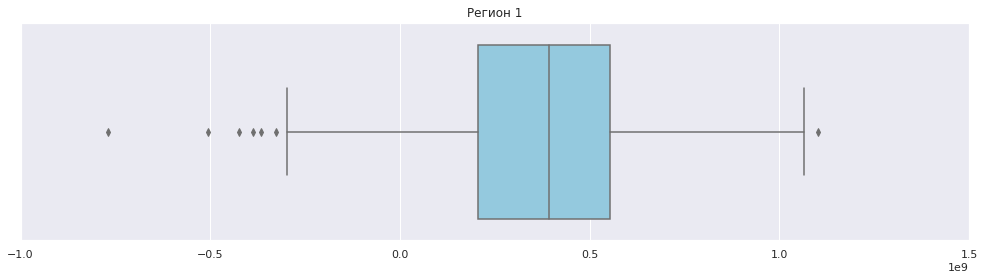

In [116]:
# расчет показателей по региону 1
profit_and_risk(target_valid_1, predicted_valid_1, 1)

Средняя прибыль в регионе 2 : 441681795.92
95%-й доверительный интервал в регионе 2 составляет от 24551179.26 до 859406669.77
Риск убытков в регионе 2 : 2.0 %


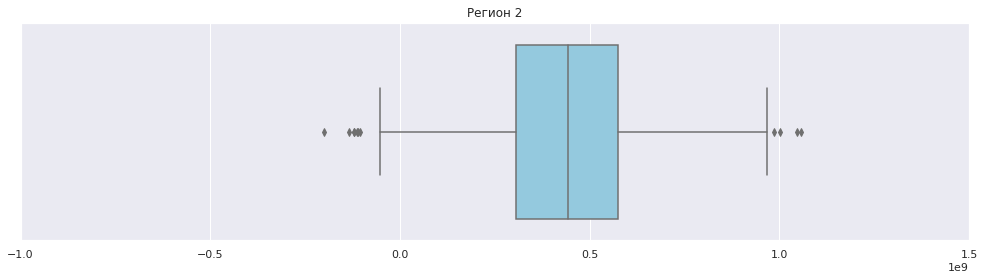

In [117]:
# расчет показателей по региону 2
profit_and_risk(target_valid_2, predicted_valid_2, 2)

Средняя прибыль в регионе 3 : 316977487.51
95%-й доверительный интервал в регионе 3 составляет от -217280655.87 до 824150945.88
Риск убытков в регионе 3 : 11.9 %


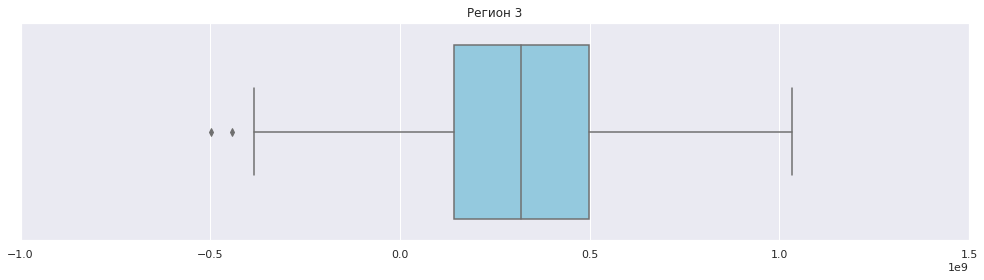

In [118]:
# расчет показателей по региону 3
profit_and_risk(target_valid_3, predicted_valid_3, 3)

**Выводы по результатам оценки прибыли и рисков в регионах:**

Регион 2 показывает наибольшую среднюю прибыль, минимальный риск убытков и самый узкий 95% доверительный интервал.

## Выводы по результатам проекта

По результатам анализа наиболее перспективным регионом для разработки скважин является **регион 2** (geo_data_1.csv) по следующим причинам:
1. Несмотря на самый низкий (из трех регионов) средний запас сырья (68.64	тыс. баррелей), регион 2 показывает наибольшую среднюю прибыль (441.7 млн.) и медианное значение.
3. Регион 2 отличается самым узким 95% доверительным интервалом.
2. Риск убытков минимальный из исследуемых регионов (2.0%) и единственный соответствует условию задачи по вероятности убытков меньше 2.5%.
3. Модель линейной регрессии на данных региона 2 показала хорошие результаты, так как в регионе наблюдалась мультиколлинеарность между целевым признаком и f2. RMSE составляет 0.89, r2 близится к 1, что является практически идеальным результатом. Хорошие результаты по качеству предсказаний значительно понижают ошибку выбора скважин с низким объемом сырья по сравнению с другими регионами.